# Water Quality Parameters Maps (CHL, TSM) - Coregistration

In this notebook, particular attention is devoted to the coregistration of the WPQ maps derived from the Sentinel-3 images. This step is important for further steps to guarantee the alignment of the maps.

In [1]:
# Styling notebook

# System
import os
import sys

# Import scripts libraries for the project
sys.path.append('./src/python')

# Import the function to update the notebook style
from nbConfig import (css_styling)

css_styling()

## 0. Import libraries

Import the required libraries and setup the current working directories.

In [2]:
# Data
import numpy as np
import pandas as pd

# Spatial Data
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import richdem as rd

# Data visualization
import matplotlib.pyplot as plt
from rasterio.plot import show_hist

# Import custom libraries
import wqpFunctions as wqp

In [3]:
# Current Working Directories
cwd = {
    'local': '.',
    'in': './in/wqp/S3',
    'out': './out/image_coregistration',
    'vector': './vector',
}

To ensure finding the best fit to the lakes coregistration from shifts, and possible distorsions, the coregistration method has been applied separately to each of the lakes.

Text(0.5, 1.0, 'Lakes shape and mask for data processing')

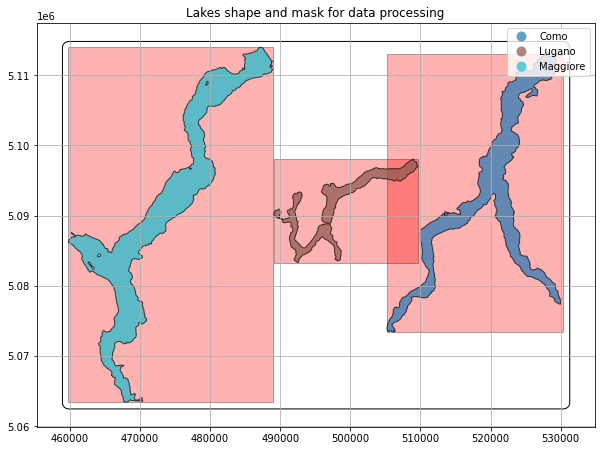

In [4]:
# Lakes shapes and mask
featureLakes = os.path.join(cwd['vector'],'simile_laghi/simile_laghi.shp')
featureGeometry = os.path.join(cwd['vector'],'simile_laghi_extent/simile_laghi_extent_600m_buff.shp')
featureBoxes = os.path.join(cwd['vector'],'simile_laghi_bboxes/simile_laghi_bboxes.shp')
# DataFrame of the lakes and mask
gdf_maskWQP = gpd.read_file(featureGeometry)
gdf_lakesWQP = gpd.read_file(featureLakes)
gdf_bboxesWQP = gpd.read_file(featureBoxes)
# Visualization of the lakes and mask
fig, ax = plt.subplots(figsize=(10, 10))
gdf_maskWQP.plot(ax = ax, color='white',edgecolor='k', alpha=1)
gdf_bboxesWQP.plot(ax = ax, color='red',edgecolor='k', alpha=0.3)
gdf_lakesWQP.plot(column='Nome', ax = ax ,edgecolor='k', alpha=0.7, legend=True)
ax.grid()
ax.set_title('Lakes shape and mask for data processing')

## 1. Coregistration

### 1.1. Images subsets - Radiance Reference Band - Slope

Master Image

Make sure to create a folder for each lake under the `./out/image_coregistration/master/slope_oa/partial`. The folders must follow the same naming which has been provided for the imported vector features (e.g. matching the records for the *'Nome'* attribute)

In [5]:
# Define the reference (master) raster for the corregistration algorithm
master_name = 'S3A_IT_20190315T094218_L1'
# master_name = 'S3A_IT_20220911T100113_L1'
oa_bands_master =  os.path.join(cwd['in'],'oa',master_name +'.tif')
master = wqp.wqp(oa_bands_master)
master.readWQP()
# Mask layer for creating he subsets
featureGeometry = './vector/simile_laghi_extent/simile_laghi_extent_600m_buff.shp'
# Cropped master raster
master.cropRasterByFeatures(featureGeometry,'Nome')
# Export masked master dataset
out_path_master = os.path.join(cwd['out'],'master','oa')
master.saveMaskedImage(os.path.join(out_path_master,'full',master.name+'_Oa_18.tif'),'wqp',band=18)
# Generate the slope layer for the master dataset
rd_master = rd.LoadGDAL(os.path.join(out_path_master,'full',master.name+'_Oa_18.tif'), no_data=0)
slope_master = rd.TerrainAttribute(rd_master, attrib='slope_riserun')
# Save the computed slope dataset
out_path_master_slope = os.path.join(cwd['out'],'master','slope_oa')
rd.SaveGDAL(os.path.join(out_path_master_slope,'full',master.name+'_Oa_18.tif'), slope_master)
# Read Reference Band Slope - Crop the slope estimates in the different lakes
slope_master = wqp.wqp(os.path.join(out_path_master_slope,'full',master_name+'_Oa_18.tif'))
slope_master.readWQP()
slope_master.cropRasterByFeatures(featureLakes, 'Nome')
for nameFeature in list(gdf_bboxesWQP.Nome):
    out_path = os.path.join(cwd['out'],'master','slope_oa','partial','{}/{}'.format(nameFeature,master_name+'_Oa_18.tif'))
    slope_master.saveMaskedImage(out_path,nameFeature, band=1)

Text(0.5, 1.0, 'Master Band for Coregistraton - S3A_IT_20190315T094218_L1')

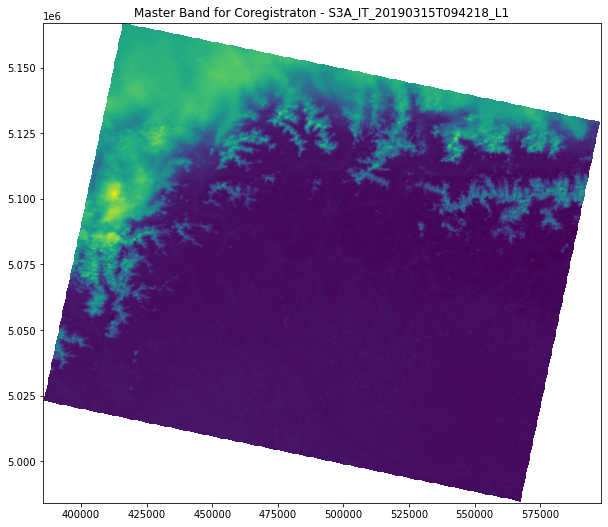

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax = rasterio.plot.show((master.image, 1), ax=ax, cmap='viridis')
ax.set_title('Master Band for Coregistraton - {}'.format(master_name))

Slave images

In [7]:
#TODO: estimate only for the missing datasets in the folder

# Output folder for the slave image
out_path_slave = os.path.join(cwd['out'],'slave','oa')
out_path_slave_slope = os.path.join(cwd['out'],'slave','slope_oa')
# Apply the mask to the coregistered (slave) images
for root, dirs, files in os.walk(os.path.join(cwd['in'],'oa')):
    for f in files:
        if (f.endswith('.tif')):
            oa_bands_slave = os.path.join(root,f)
            slave = wqp.wqp(oa_bands_slave)
            slave.readWQP()
            slave.cropRasterByFeatures(featureGeometry,'Nome')
            slave.saveMaskedImage(os.path.join(out_path_slave,'full',slave.name+'_Oa_18.tif'),'wqp',band=18)
            rd_slave = rd.LoadGDAL(os.path.join(out_path_slave,'full',slave.name+'_Oa_18.tif'), no_data=0)
            slope_slave = rd.TerrainAttribute(rd_slave, attrib='slope_riserun')
            rd.SaveGDAL(os.path.join(out_path_slave_slope,'full',slave.name+'_Oa_18.tif'), slope_slave)
            try:
                for nameFeature in list(gdf_bboxesWQP.Nome):
                    slope_slave = wqp.wqp(os.path.join(out_path_slave_slope,'full',slave.name+'_Oa_18.tif'))
                    slope_slave.readWQP()
                    slope_slave.cropRasterByFeatures(featureLakes, 'Nome')
                    out_path = os.path.join(out_path_slave_slope,'partial',nameFeature,slave.name+'_Oa_18.tif')
                    slope_slave.saveMaskedImage(out_path,nameFeature, band=1)
            except:
                print(slave.name,': ', nameFeature + ', slope has not been computed')

### 1.3. Subset WQP - sample maps

In order to perform the coregistration, it is needed to input the reference and coregistered images with the same dimensions. For this reason, and intermediate step previous to the coregistration is to subset the WQP images with the same bounding boxes. The images subsets target each of the lakes in order to apply the coregistration separately.

In [ ]:
# Output folder for the slave image
in_path = './in/data/wqp/L8/wqp_high_clouds/lswt'
out_path = os.path.join('./in/data\wqp/L8/wqp_high_clouds/lswt/cropped')
sensor = 'S3'
shared_maps = list(set(os.listdir(in_path)).intersection(os.listdir(out_path)))
missing_maps = list(set(os.listdir(in_path)) ^ set(os.listdir(out_path)))
print((missing_maps))
# Apply the mask to the coregistered (slave) images
for root, dirs, files in os.walk(in_path):
    for f in missing_maps:
        if ((f.endswith('.tif')) & (dirs == ['cropped'])):
            try:
                chl_map = os.path.join(in_path,f)
                wqp_map = wqp.wqp(chl_map)
                wqp_map.readWQP()
                wqp_map.cropRasterByFeatures(featureGeometry,'Nome')
                wqp_map.saveMaskedImage(os.path.join(out_path,f),'wqp',band=1)
                wqp_map.image.close()
            except:
                # Open a file with access mode 'a'
                file_object = open(os.path.join('./in/data\wqp/L8/wqp_high_clouds/lswt/cropped',f'error_images_{sensor}.txt'), 'a')
                # Append 'hello' at the end of file
                file_object.write(wqp_map.name)
                file_object.write("\n")
                # Close the file
                file_object.close()

FileNotFoundError: [Errno 2] No such file or directory: './in/wqp/L8/wqp_high_clouds/lswt/cropped'

In [24]:
a = os.listdir('./in/data/wqp/S3/wqp_no_clip/tsm')[-1]
print(a.split('_')[3])
any(a.split('_')[3] in s for s in os.listdir('./out/Coregistration/wqp/S3/full/tsm'))

FileNotFoundError: [Errno 2] No such file or directory: './in/data/wqp/S3/wqp_no_clip/tsm'

Chlorophyll-a and Total Suspended Matter Maps subset. 

In [8]:
# Output folder for the slave image
wqps = ['chl','tsm']
out_path_crop_full = os.path.join(cwd['out'],'wqp', 'full')
out_path_crop_partial = os.path.join(cwd['out'],'wqp', 'partial')
# Apply the mask to the coregistered (slave) images
for wmap in wqps:
    wqp_path = os.path.join(cwd['in'],'wqp',wmap)
    for root, dirs, files in os.walk(wqp_path):
        for f in files:
            a = os.listdir(wqp_path)
            if ((f.endswith('.tif'))):
                w_map = os.path.join(root,f)
                wqp_map = wqp.wqp(w_map)
                wqp_map.readWQP()
                wqp_map.cropRasterByFeatures(featureGeometry,'Nome')
                wqp_map.saveMaskedImage(os.path.join(out_path_crop_full,wmap,wqp_map.name+'.tif'),'wqp',band=1)
                wqp_map.cropRasterByFeatures(featureBoxes,'Nome')
                for nameFeature in list(gdf_bboxesWQP.Nome):
                    try:
                        wqp_map.saveMaskedImage(os.path.join(out_path_crop_partial, wmap,nameFeature,wqp_map.name+'.tif'),nameFeature,band=1)
                    except:
                        print(f,':',nameFeature)

### 1.4. Image coregistration

Data Visualization and Analysis

In [9]:
import numpy as np
from skimage.io import imread
import pylab as pl

Flow computation

In [10]:
sys.path.append('./src/python/gefolki/python')
from algorithm import EFolki
from tools import wrapData

In [11]:
def saveMaskedImage(out_path,in_file,data,transf):
    with rasterio.open(in_file) as src:
        profile = src.profile.copy()
        profile.update({
                'dtype': 'float32',
                'height': data.shape[0],
                'width': data.shape[1],
                'transform': transf
         })  

    with rasterio.open(out_path, 'w', **profile) as dst:
        data[data<=0] = np.nan
        dst.write_band(1, data)

In [12]:
from rasterio.merge import merge

for wmap in wqps:
    in_path_master = './out/image_coregistration/master/slope_oa/partial'
    in_path_slave = './out/image_coregistration/slave/slope_oa/partial'
    in_path_wqp = f'./out/image_coregistration/wqp/partial/{wmap}'
    in_path_wqp_slope = f'./out/image_coregistration/master/slope_oa/full'
    out_path_wqp = f'./out/image_coregistration/wqp/partial_coregistered/{wmap}'
    out_path_coregistered = f'./out/image_coregistration/wqp/full_coregistered/{wmap}'
    typology = wmap.upper()
    # Image coregistration
    for root, dirs, files in os.walk('./out/image_coregistration/slave/slope_oa/full'):
        for f in files:
            print(f)
            if (f.endswith('.tif') and (any(f.split('_')[2] in s for s in os.listdir(f'./out/image_coregistration/wqp/full_coregistered/{wmap}')))==False):
                raster_collection = dict()
                for nameFeature in list(gdf_bboxesWQP.Nome):
                    try:
                        # Determine the paths to the partial rasters (crop per lake)
                        master_path = os.path.join(in_path_master,nameFeature,master.name+'_Oa_18.tif')
                        slave_path = os.path.join(in_path_slave,nameFeature,f)
                        s_n = f.split('_')[:-2]
                        s_n.insert(1,typology)
                        slave_name_wqp = '_'.join(s_n)+'.tif'
                        wqp_path = os.path.join(in_path_wqp,nameFeature,slave_name_wqp)
                        # Read the images
                        master_im = imread(master_path)
                        slave_im = imread(slave_path)
                        wqp_map = imread(wqp_path)
                        # Read shape of the maser raster (fix width and height of the rasters for the coregistered images following the reference band)
                        master_width = master_im.shape[0]
                        master_height = master_im.shape[1]
                        # Remove the nan values (GeFolki processing requirement)
                        master_im = master_im.astype(np.float32)
                        slave_im = slave_im.astype(np.float32)
                        wqp_map = wqp_map.astype(np.float32)
                        master_im = np.nan_to_num(master_im[:master_width-1,:master_height-1], copy=True, nan=0.0, posinf=None, neginf=None)
                        slave_im = np.nan_to_num(slave_im[:master_width-1,:master_height-1], copy=True, nan=0.0, posinf=None, neginf=None)
                        # Flow computation
                        u, v = EFolki(master_im, slave_im, iteration=4, radius=[32,28,20,16,8], rank=4, levels=2)
                        # Resampling and final result
                        WQPrecalee = wrapData(wqp_map[:master_width-1,:master_height-1], u, v)
                        # Export partial datasets
                        # Import the sample dataset master - Reference coregistration band
                        src_master = wqp.wqp(master_path)
                        src_master.readWQP()
                        # Save the coregistered WQP map
                        src_master.writeWQP(os.path.join(out_path_wqp,nameFeature,wqp_path.split('/')[-1]),WQPrecalee)

                        # Merge data
                        raster_collection[nameFeature] = src_master.create_dataset(WQPrecalee,src_master.image.profile['transform'])
                    except:
                        print(f,': ', nameFeature, 'CHECK!')

                wqp_map = wqp.wqp(os.path.join(in_path_wqp_slope,master_name+'_Oa_18.tif'))
                wqp_map.readWQP()
                if (len(raster_collection)>0):
                    raster_col_lst = []
                    for x in ['Lugano','Como','Maggiore']:
                        if x in list(raster_collection.keys()):
                            raster_col_lst.append(raster_collection[x])
                    merged, transf = merge(raster_col_lst)
                    merged[0][merged[0]<=0]=0
                    saveMaskedImage(os.path.join(out_path_coregistered,slave_name_wqp),wqp_map.path,merged[0],transf)

S3A_IT_20190315T094218_L1_Oa_18.tif
S3A_IT_20190315T094218_L1_Oa_18.tif :  Maggiore CHECK!
S3A_IT_20190315T094218_L1_Oa_18.tif :  Como CHECK!
S3A_IT_20190315T094218_L1_Oa_18.tif :  Lugano CHECK!
S3A_IT_20220911T100113_L1_Oa_18.tif
S3A_IT_20220911T100113_L1_Oa_18.tif :  Maggiore CHECK!
S3A_IT_20220911T100113_L1_Oa_18.tif :  Como CHECK!
S3A_IT_20220911T100113_L1_Oa_18.tif :  Lugano CHECK!
S3A_IT_20221001T094230_L1_Oa_18.tif
S3A_IT_20221002T091619_L1_Oa_18.tif
S3A_IT_20190315T094218_L1_Oa_18.tif
S3A_IT_20190315T094218_L1_Oa_18.tif :  Maggiore CHECK!
S3A_IT_20190315T094218_L1_Oa_18.tif :  Como CHECK!
S3A_IT_20190315T094218_L1_Oa_18.tif :  Lugano CHECK!
S3A_IT_20220911T100113_L1_Oa_18.tif
S3A_IT_20220911T100113_L1_Oa_18.tif :  Maggiore CHECK!
S3A_IT_20220911T100113_L1_Oa_18.tif :  Como CHECK!
S3A_IT_20220911T100113_L1_Oa_18.tif :  Lugano CHECK!
S3A_IT_20221001T094230_L1_Oa_18.tif
S3A_IT_20221002T091619_L1_Oa_18.tif
